In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

# Any results you write to the current directory are saved as output.

In [2]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
tf.__version__

'2.6.2'

In [4]:
# Set some parameters
im_width = 256
im_height = 256

In [5]:
train_files = []
mask_files = glob('../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

print(train_files[:10])
print(mask_files[:10])

['../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_43.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_39.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_7.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_31.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_6.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_38.tif']
['../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_1986030

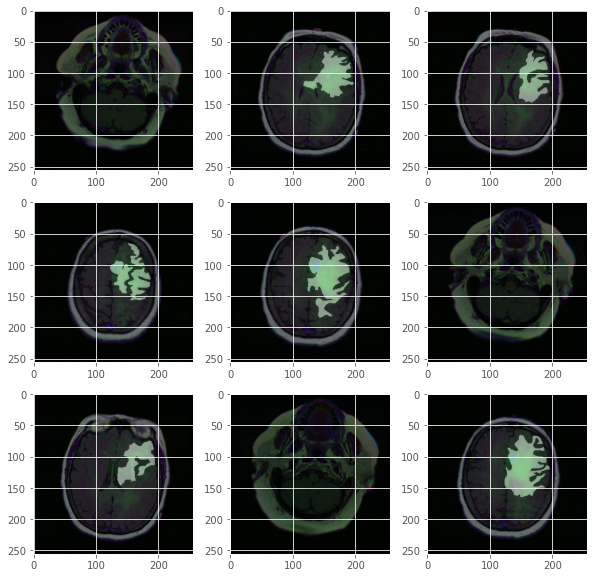

In [6]:
#Lets plot some samples
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=train_files[i]
    msk_path=mask_files[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
plt.show()

In [7]:
def diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    return '1' if value > 0 else '0'
df = pd.DataFrame({"image_path": train_files,
                   "mask_path": mask_files,
                  "diagnosis":[diagnosis(x) for x in mask_files]})
df.head()

,image_path,mask_path,diagnosis
0,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
1,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
2,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1
3,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1
4,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1


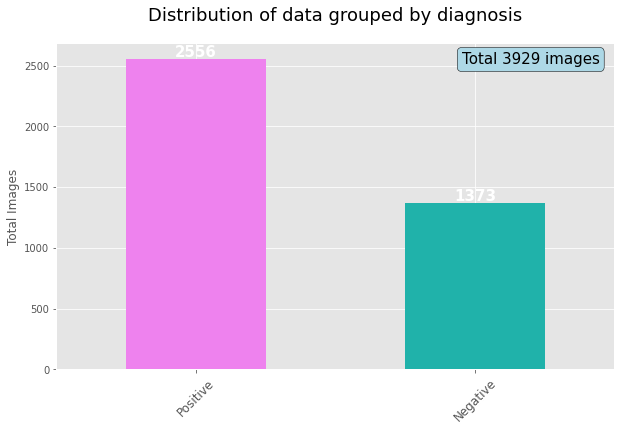

In [8]:
# Plot
ax = df.diagnosis.value_counts().plot(kind='bar',
                                      stacked=True,
                                      figsize=(10, 6),
                                     color=["violet", "lightseagreen"])


ax.set_xticklabels(["Positive", "Negative"], rotation=45, fontsize=12);
ax.set_ylabel('Total Images', fontsize = 12)
ax.set_title("Distribution of data grouped by diagnosis",fontsize = 18, y=1.05)

# Annotate
for i, rows in enumerate(df.diagnosis.value_counts().values):
    ax.annotate(int(rows), xy=(i, rows-12), 
                rotation=0, color="white", 
                ha="center", verticalalignment='bottom', 
                fontsize=15, fontweight="bold")
    
ax.text(1.2, 2550, f"Total {len(df)} images", size=15,
        color="black",
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   fc=("lightblue"),
                   ec=("black"),
                   )
         );

In [9]:
df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})
df_train, df_test = train_test_split(df,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2828, 2)
(708, 2)
(393, 2)


In [10]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

In [11]:
def unet(input_size=(128, 128, 3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [12]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [13]:
from sklearn.model_selection import KFold
import pandas

kf = KFold(n_splits = 5, shuffle=False)
df = pandas.DataFrame(data={"filename": train_files, 'mask' : mask_files})

df2 = df.sample(frac=1).reset_index(drop=True)

In [16]:

train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

histories = []
losses = []
accuracies = []
dicecoefs = []
ious = []

EPOCHS = 40
BATCH_SIZE = 32

for k, (train_index, test_index) in enumerate(kf.split(df2)):
    train_data_frame = df2.iloc[train_index]
    test_data_frame = df2.iloc[test_index]
    
    train_gen = train_generator(train_data_frame, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
    test_gener = train_generator(test_data_frame, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    
    model = unet(input_size=(im_height, im_width, 3))
    
    model.compile(optimizer=Adam(lr=5e-6), loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])
    callbacks = [ModelCheckpoint(str(k+1) + '_unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)]
    history = model.fit(train_gen,
                          steps_per_epoch=len(train_data_frame) / BATCH_SIZE, 
                          epochs=EPOCHS, 
                          callbacks=callbacks,
                          validation_data = test_gener,
                          validation_steps=len(test_data_frame) / BATCH_SIZE)
    
    model = load_model(str(k+1) + '_unet_brain_mri_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
    
    test_gen = train_generator(test_data_frame, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    results = model.evaluate(test_gen, steps=len(test_data_frame) / BATCH_SIZE)
    results = dict(zip(model.metrics_names,results))
    
    histories.append(history)
    accuracies.append(results['binary_accuracy'])
    losses.append(results['loss'])
    dicecoefs.append(results['dice_coef'])
    ious.append(results['iou'])

Found 3143 validated image filenames.
Found 3143 validated image filenames.
Epoch 1/40
99/98 [==============================] - ETA: 0s - loss: -0.0209 - binary_accuracy: 0.1250 - iou: 0.0107 - dice_coef: 0.0211Found 786 validated image filenames.
Found 786 validated image filenames.
98/98 [==============================] - 93s 936ms/step - loss: -0.0209 - binary_accuracy: 0.1250 - iou: 0.0107 - dice_coef: 0.0211 - val_loss: -0.0196 - val_binary_accuracy: 0.2199 - val_iou: 0.0099 - val_dice_coef: 0.0195

Epoch 00001: val_loss improved from inf to -0.01958, saving model to 1_unet_brain_mri_seg.hdf5
Epoch 2/40
98/98 [==============================] - 90s 919ms/step - loss: -0.0217 - binary_accuracy: 0.3406 - iou: 0.0111 - dice_coef: 0.0219 - val_loss: -0.0205 - val_binary_accuracy: 0.3985 - val_iou: 0.0105 - val_dice_coef: 0.0206

Epoch 00002: val_loss improved from -0.01958 to -0.02054, saving model to 1_unet_brain_mri_seg.hdf5
Epoch 3/40
98/98 [==============================] - 90s 916

2022-01-20 15:14:53.060206: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.38GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-01-20 15:14:53.066439: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.38GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


98/98 [==============================] - 92s 940ms/step - loss: -0.5942 - binary_accuracy: 0.9925 - iou: 0.4302 - dice_coef: 0.5921 - val_loss: -0.6355 - val_binary_accuracy: 0.9933 - val_iou: 0.4713 - val_dice_coef: 0.6360

Epoch 00008: val_loss improved from -0.62643 to -0.63551, saving model to 5_unet_brain_mri_seg.hdf5
Epoch 9/40
98/98 [==============================] - 93s 945ms/step - loss: -0.6257 - binary_accuracy: 0.9930 - iou: 0.4660 - dice_coef: 0.6271 - val_loss: -0.6461 - val_binary_accuracy: 0.9937 - val_iou: 0.4831 - val_dice_coef: 0.6428

Epoch 00009: val_loss improved from -0.63551 to -0.64608, saving model to 5_unet_brain_mri_seg.hdf5
Epoch 10/40
98/98 [==============================] - 92s 940ms/step - loss: -0.6396 - binary_accuracy: 0.9933 - iou: 0.4759 - dice_coef: 0.6361 - val_loss: -0.6051 - val_binary_accuracy: 0.9906 - val_iou: 0.4400 - val_dice_coef: 0.6055

Epoch 00010: val_loss did not improve from -0.64608
Epoch 11/40
98/98 [==============================]

2022-01-20 16:03:01.858950: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.38GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-01-20 16:03:01.861579: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.38GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


98/98 [==============================] - 91s 931ms/step - loss: -0.7509 - binary_accuracy: 0.9952 - iou: 0.6073 - dice_coef: 0.7509 - val_loss: -0.7782 - val_binary_accuracy: 0.9955 - val_iou: 0.6410 - val_dice_coef: 0.7777

Epoch 00040: val_loss improved from -0.76664 to -0.77819, saving model to 5_unet_brain_mri_seg.hdf5
Found 785 validated image filenames.
Found 785 validated image filenames.
24/24 [==============================] - 5s 209ms/step - loss: -0.7660 - binary_accuracy: 0.9955 - iou: 0.6288 - dice_coef: 0.7681


# Result and graphs visualizations

In [18]:
print('accuracies : ', accuracies)
print('losses : ', losses)
print('dicecoefs : ', dicecoefs)
print('ious : ', ious)

print('-----------------------------------------------------------------------------')
print('-----------------------------------------------------------------------------')

print('average accuracy : ', np.mean(np.array(accuracies)))
print('average loss : ', np.mean(np.array(losses)))
print('average dicecoefs : ', np.mean(np.array(dicecoefs)))
print('average ious : ', np.mean(np.array(ious)))
print()

print('standard deviation of accuracy : ', np.std(np.array(accuracies)))
print('standard deviation of loss : ', np.std(np.array(losses)))
print('standard deviation of dicecoefs : ', np.std(np.array(dicecoefs)))
print('standard deviation of ious : ', np.std(np.array(ious)))

accuracies :  [0.9951940774917603, 0.99500972032547, 0.9948055148124695, 0.9946470260620117, 0.9955109357833862]
losses :  [-0.739607036113739, -0.7261297702789307, -0.7062891125679016, -0.751007616519928, -0.7660438418388367]
dicecoefs :  [0.7377970218658447, 0.7247002124786377, 0.7084593176841736, 0.7506504654884338, 0.7680866718292236]
ious :  [0.5896059274673462, 0.5764090418815613, 0.5579993724822998, 0.6066029071807861, 0.6288125514984131]
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
average accuracy :  0.9950334548950195
average loss :  -0.7378154754638672
average dicecoefs :  0.7379387378692627
average ious :  0.5918859601020813

standard deviation of accuracy :  0.0003018724470181374
standard deviation of loss :  0.02051609225228844
standard deviation of dicecoefs :  0.020565995203301254
standard deviation of ious :  0.02438522524153629


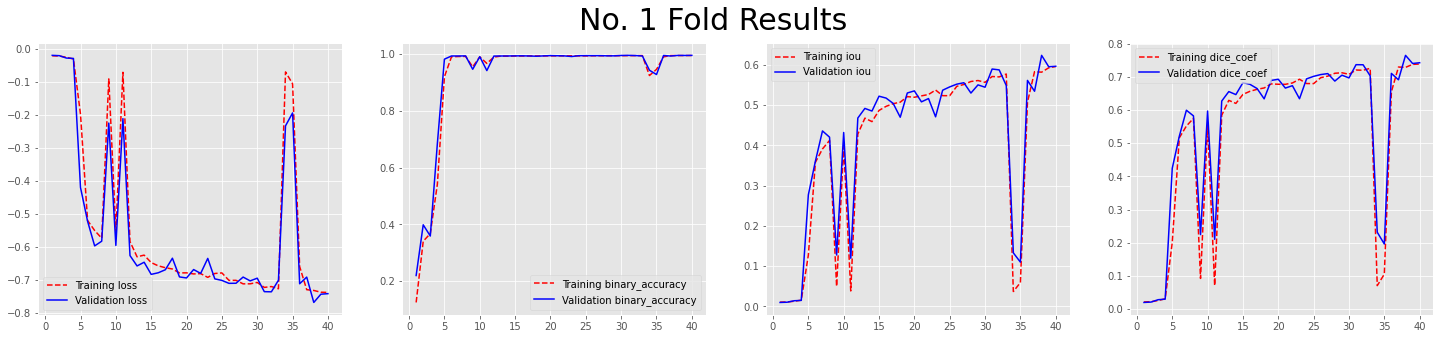

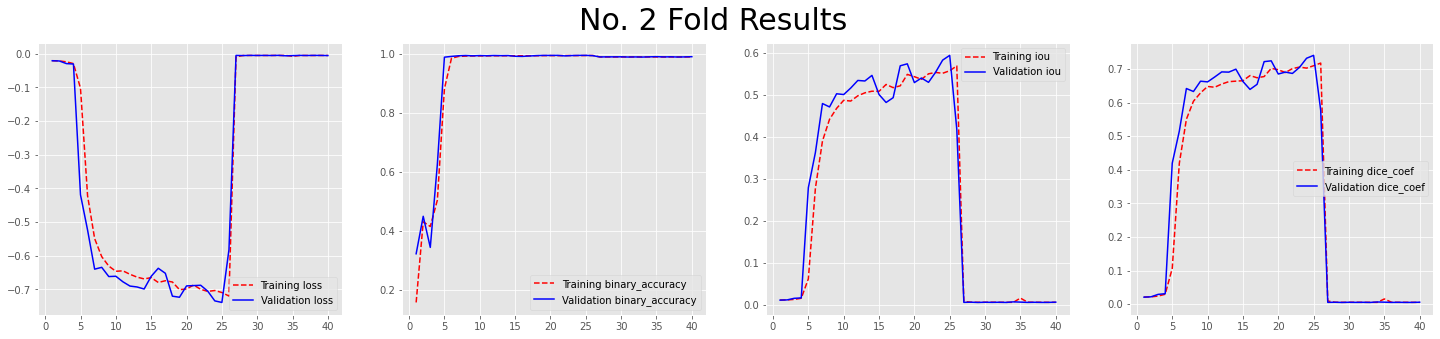

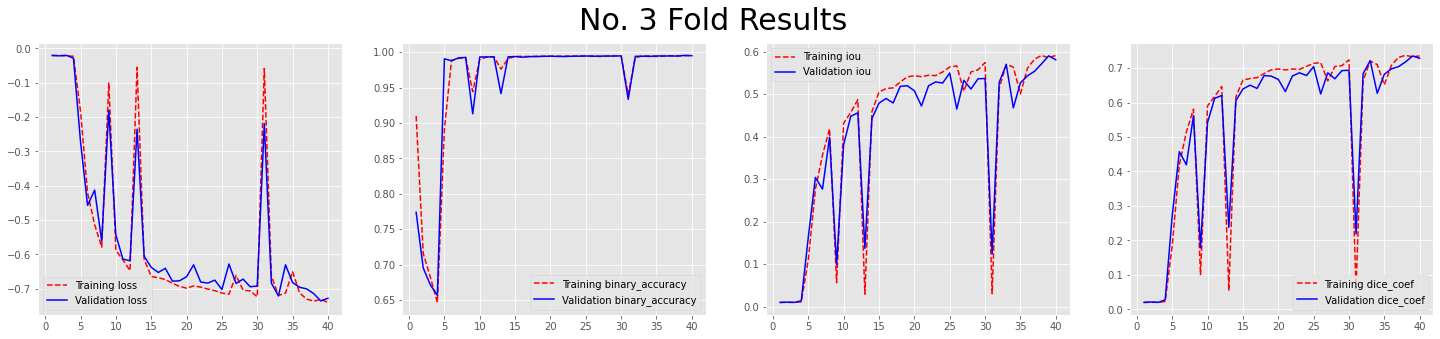

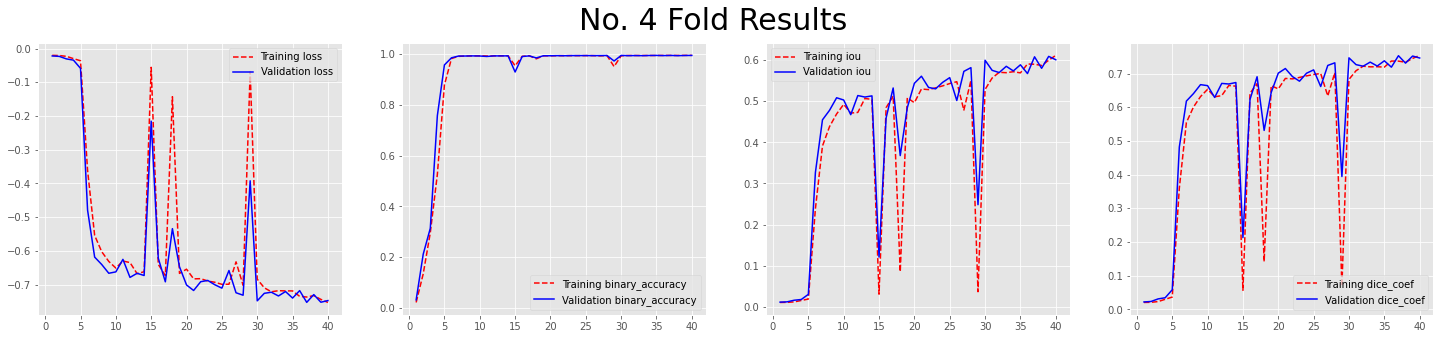

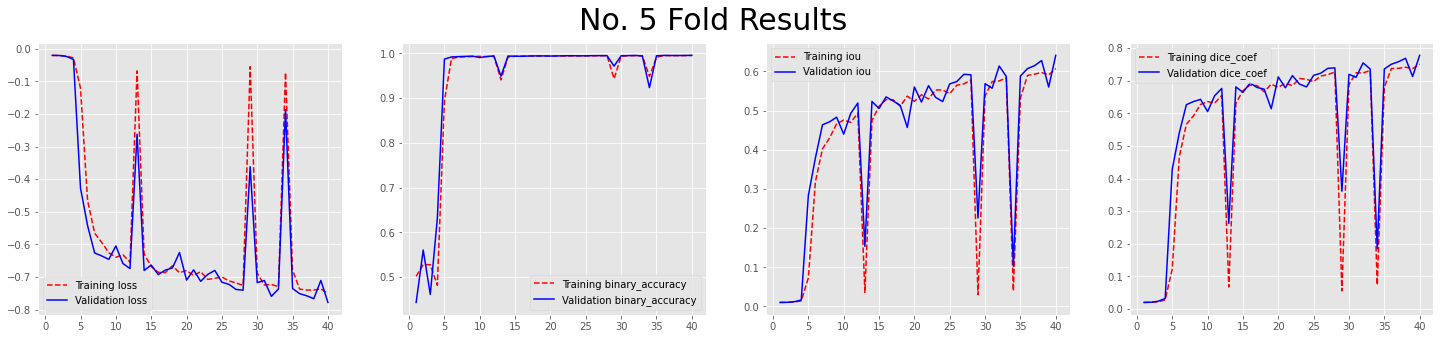

In [19]:
import pickle

for h, history in enumerate(histories):

    keys = history.history.keys()
    fig, axs = plt.subplots(1, len(keys)//2, figsize = (25, 5))
    fig.suptitle('No. ' + str(h+1) + ' Fold Results', fontsize=30)

    for k, key in enumerate(list(keys)[:len(keys)//2]):
        training = history.history[key]
        validation = history.history['val_' + key]

        epoch_count = range(1, len(training) + 1)

        axs[k].plot(epoch_count, training, 'r--')
        axs[k].plot(epoch_count, validation, 'b-')
        axs[k].legend(['Training ' + key, 'Validation ' + key])
            
    with open(str(h+1) + '_mri_trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

# Model selection and evaluation

In [20]:
selectors = np.array(ious)
selector = np.argmin(abs(selectors - np.mean(selectors)))

In [21]:
model = load_model(str(selector+1) + '_unet_brain_mri_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

Some prediction results:

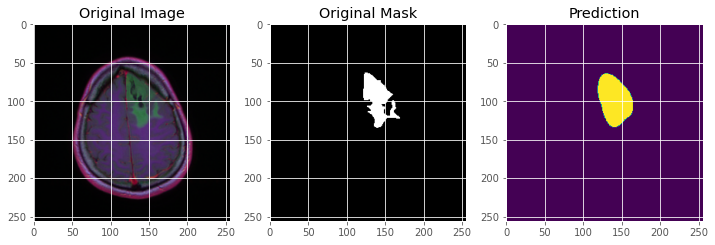

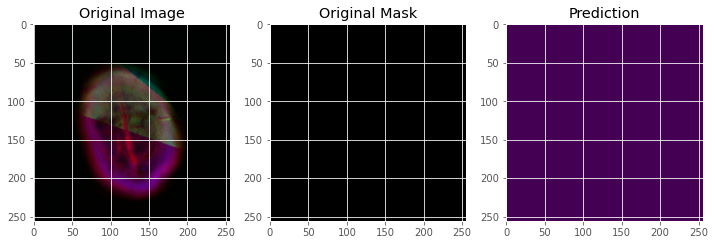

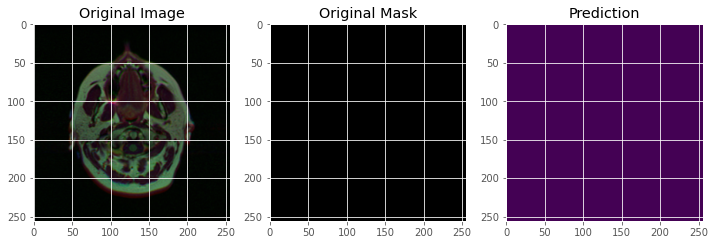

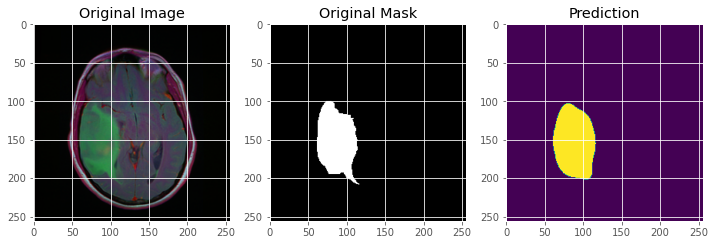

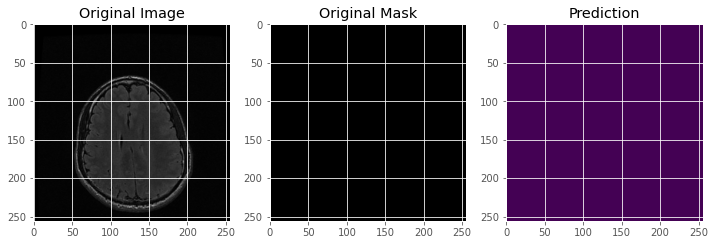

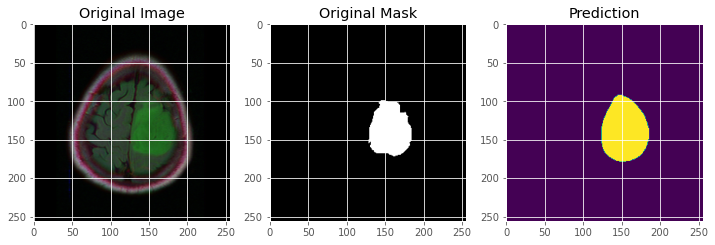

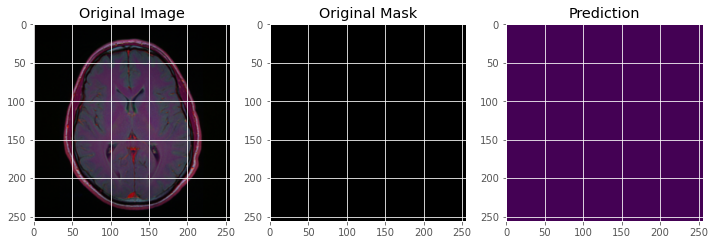

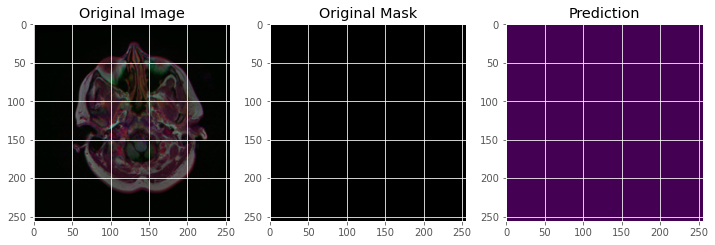

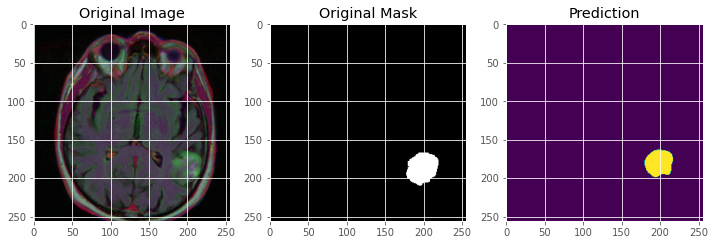

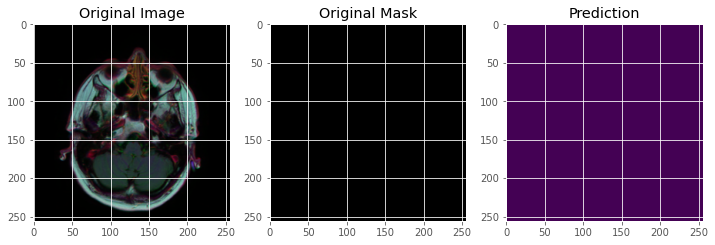

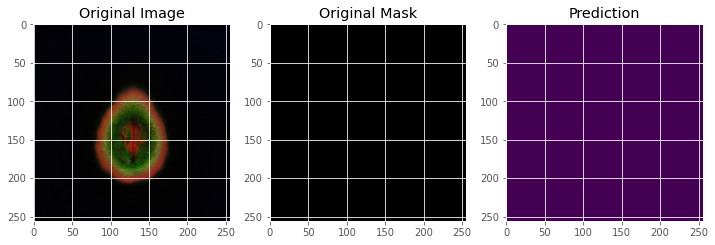

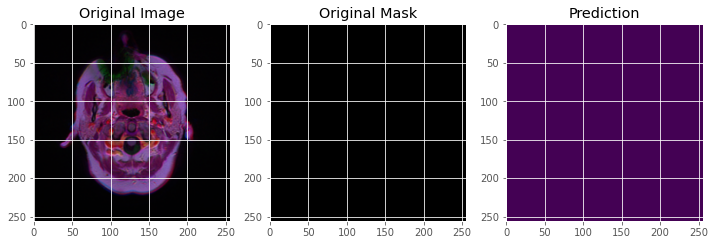

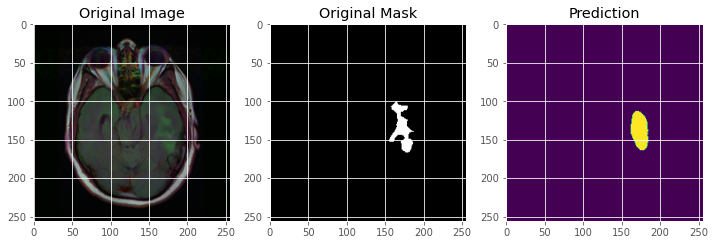

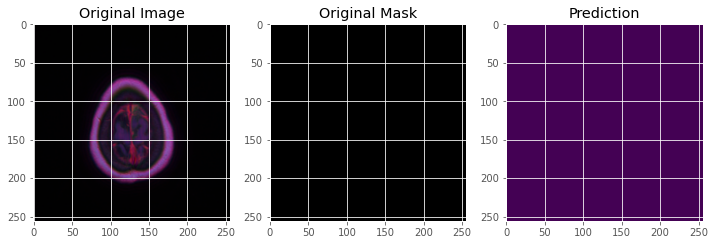

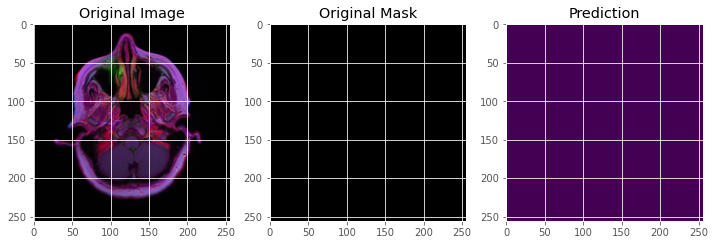

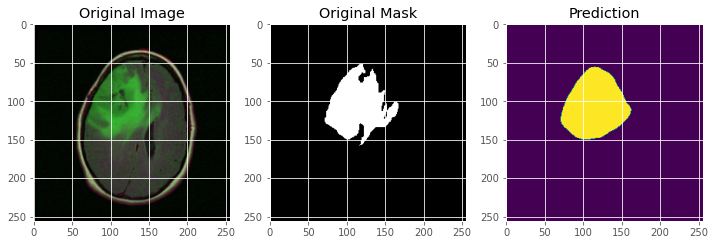

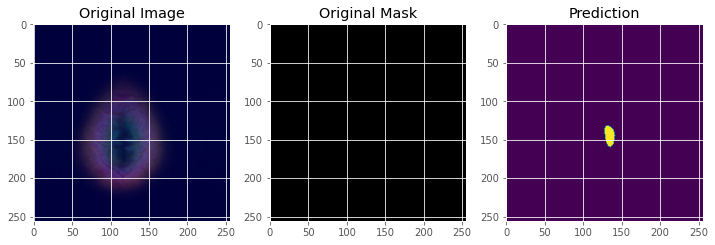

In [ ]:
for i in range(20):
    index=np.random.randint(1,len(test_data_frame.index))
    img = cv2.imread(test_data_frame['filename'].iloc[index])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(cv2.imread(test_data_frame['filename'].iloc[index]))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(test_data_frame['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()